# Gaussian Mixture Model with ADVI

Here, we describe how to use ADVI for inference of Gaussian mixture model. First, we will show that inference with ADVI does not need to modify the stochastic model, just call a function. Then, we will show how to use mini-batch, which is useful for large dataset. In this case, where the model should be slightly changed. 

First, create artificial data from a mixuture of two Gaussian components.  

env: THEANO_FLAGS=device=cpu,floatX=float32


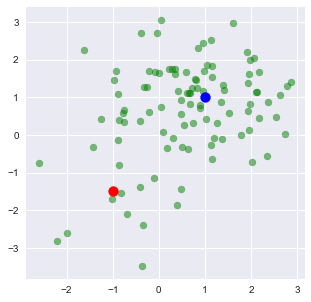

In [1]:
%matplotlib inline
%env THEANO_FLAGS=device=cpu,floatX=float32
import theano

import pymc3 as pm
from pymc3 import Normal, Metropolis, sample, MvNormal, Dirichlet, \
    DensityDist, find_MAP, NUTS, Slice
import theano.tensor as tt
from theano.tensor.nlinalg import det
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

n_samples = 100
rng = np.random.RandomState(123)
ms = np.array([[-1, -1.5], [1, 1]])
ps = np.array([0.2, 0.8])

zs = np.array([rng.multinomial(1, ps) for _ in range(n_samples)]).T
xs = [z[:, np.newaxis] * rng.multivariate_normal(m, np.eye(2), size=n_samples)
      for z, m in zip(zs, ms)]
data = np.sum(np.dstack(xs), axis=2)

plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], c='g', alpha=0.5)
plt.scatter(ms[0, 0], ms[0, 1], c='r', s=100)
plt.scatter(ms[1, 0], ms[1, 1], c='b', s=100)

Gaussian mixture models are usually constructed with categorical random variables. However, any discrete rvs does not fit ADVI. Here, class assignment variables are marginalized out, giving weighted sum of the probability for the gaussian components. The log likelihood of the total probability is calculated using logsumexp, which is a standard technique for making this kind of calculation stable. 

In the below code, DensityDist class is used as the likelihood term. The second argument, logp_gmix(mus, pi, np.eye(2)), is a python function which recieves observations (denoted by 'value') and returns the tensor representation of the log-likelihood. 

In [2]:
from pymc3.math import logsumexp

# Log likelihood of normal distribution
def logp_normal(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.) * (k * tt.log(2 * np.pi) + tt.log(1./det(tau)) +
                         (delta(mu).dot(tau) * delta(mu)).sum(axis=1))

# Log likelihood of Gaussian mixture distribution
def logp_gmix(mus, pi, tau):
    def logp_(value):        
        logps = [tt.log(pi[i]) + logp_normal(mu, tau, value)
                 for i, mu in enumerate(mus)]
            
        return tt.sum(logsumexp(tt.stacklists(logps)[:, :n_samples], axis=0))

    return logp_

with pm.Model() as model:
    mus = [MvNormal('mu_%d' % i, 
                    mu=pm.floatX(np.zeros(2)), 
                    tau=pm.floatX(0.1 * np.eye(2)), 
                    shape=(2,))
           for i in range(2)]
    pi = Dirichlet('pi', a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data)

For comparison with ADVI, run MCMC. 

In [3]:
with model:
    start = find_MAP()
    step = Metropolis()
    trace = sample(1000, step, start=start)

         Current function value: 347.140019
         Iterations: 2
         Function evaluations: 63
         Gradient evaluations: 52


100%|██████████| 1500/1500 [00:02<00:00, 631.59it/s]


Check posterior of component means and weights. We can see that the MCMC samples of the component mean for the lower-left component varied more than the upper-right due to the difference of the sample size of these clusters. 

(-6, 6)

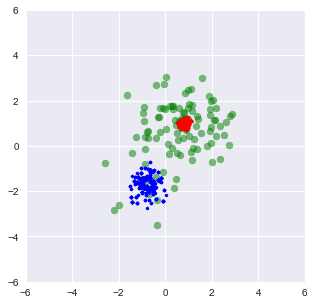

In [4]:
plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')
mu_0, mu_1 = trace['mu_0'], trace['mu_1']
plt.scatter(mu_0[-500:, 0], mu_0[-500:, 1], c="r", s=10)
plt.scatter(mu_1[-500:, 0], mu_1[-500:, 1], c="b", s=10)
plt.xlim(-6, 6)
plt.ylim(-6, 6)

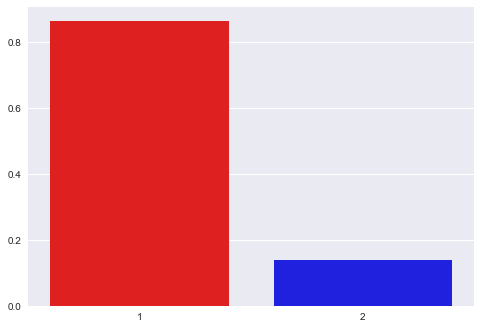

In [5]:
sns.barplot([1, 2], np.mean(trace['pi'][-5000:], axis=0), 
            palette=['red', 'blue'])

We can use the same model with ADVI as follows. 

In [8]:
with pm.Model() as model:
    mus = [MvNormal('mu_%d' % i, mu=pm.floatX(np.zeros(2)), tau=pm.floatX(0.1 * np.eye(2)), shape=(2,))
           for i in range(2)]
    pi = Dirichlet('pi', a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data)

with model:
    %time approx = pm.fit(n=4500, obj_optimizer=pm.adagrad(learning_rate=1e-1))
gbij = approx.gbij
means = gbij.rmap(approx.mean.eval())
cov = approx.cov.eval()
sds = gbij.rmap(np.diag(cov)**.5)

Average Loss = 323.94: 100%|██████████| 4500/4500 [00:01<00:00, 3286.74it/s]
Finished [100%]: Average Loss = 323.94


CPU times: user 3.75 s, sys: 44.1 ms, total: 3.79 s
Wall time: 3.8 s


The function returns three variables. 'means' and 'sds' are the mean and standart deviations of the variational posterior. Note that these values are in the transformed space, not in the original space. For random variables in the real line, e.g., means of the Gaussian components, no transformation is applied. Then we can see the variational posterior in the original space. 

(-6, 6)

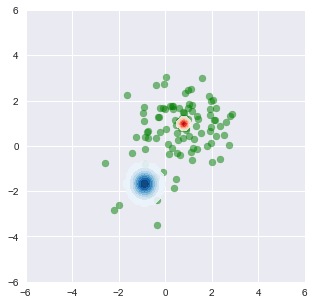

In [9]:
from copy import deepcopy

mu_0, sd_0 = means['mu_0'], sds['mu_0']
mu_1, sd_1 = means['mu_1'], sds['mu_1']

def logp_normal_np(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.) * (k * np.log(2 * np.pi) + np.log(1./np.linalg.det(tau)) +
                         (delta(mu).dot(tau) * delta(mu)).sum(axis=1))

def threshold(zz):    
    zz_ = deepcopy(zz)
    zz_[zz < np.max(zz) * 1e-2] = None
    return zz_

def plot_logp_normal(ax, mu, sd, cmap):
    f = lambda value: np.exp(logp_normal_np(mu, np.diag(1 / sd**2), value))
    g = lambda mu, sd: np.arange(mu - 3, mu + 3, .1)
    xx, yy = np.meshgrid(g(mu[0], sd[0]), g(mu[1], sd[1]))
    zz = f(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).reshape(xx.shape)
    ax.contourf(xx, yy, threshold(zz), cmap=cmap, alpha=0.9)
           
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')
plot_logp_normal(ax, mu_0, sd_0, cmap='Reds')
plot_logp_normal(ax, mu_1, sd_1, cmap='Blues')
plt.xlim(-6, 6)
plt.ylim(-6, 6)

TODO: We need to backward-transform 'pi', which is transformed by 'stick_breaking'. 

'elbos' contains the trace of ELBO, showing stochastic convergence of the algorithm. 

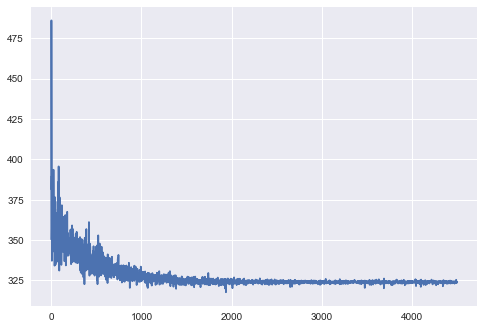

In [10]:
plt.plot(approx.hist)

To demonstrate that ADVI works for large dataset with mini-batch, let's create 100,000 samples from the same mixture distribution. 

(-6, 6)

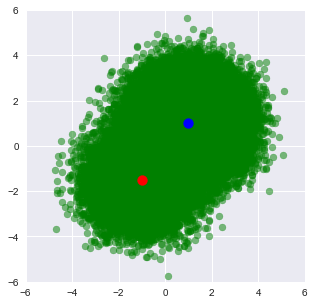

In [11]:
n_samples = 100000

zs = np.array([rng.multinomial(1, ps) for _ in range(n_samples)]).T
xs = [z[:, np.newaxis] * rng.multivariate_normal(m, np.eye(2), size=n_samples)
      for z, m in zip(zs, ms)]
data = np.sum(np.dstack(xs), axis=2)

plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], c='g', alpha=0.5)
plt.scatter(ms[0, 0], ms[0, 1], c='r', s=100)
plt.scatter(ms[1, 0], ms[1, 1], c='b', s=100)
plt.xlim(-6, 6)
plt.ylim(-6, 6)

MCMC took 55 seconds, 20 times longer than the small dataset. 

In [12]:
with pm.Model() as model:
    mus = [MvNormal('mu_%d' % i, mu=pm.floatX(np.zeros(2)), tau=pm.floatX(0.1 * np.eye(2)), shape=(2,))
           for i in range(2)]
    pi = Dirichlet('pi', a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data)
    
    start = find_MAP()
    step = Metropolis()
    trace = sample(1000, step, start=start)

         Current function value: 365347.054715
         Iterations: 4
         Function evaluations: 71
         Gradient evaluations: 59


100%|██████████| 1500/1500 [01:48<00:00, 11.93it/s]


Posterior samples are concentrated on the true means, so looks like single point for each component. 

(-6, 6)

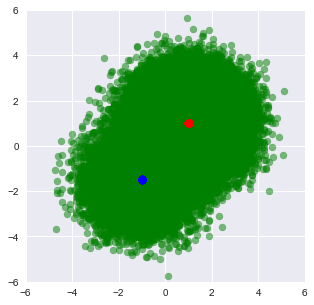

In [13]:
plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')
mu_0, mu_1 = trace['mu_0'], trace['mu_1']
plt.scatter(mu_0[-500:, 0], mu_0[-500:, 1], c="r", s=50)
plt.scatter(mu_1[-500:, 0], mu_1[-500:, 1], c="b", s=50)
plt.xlim(-6, 6)
plt.ylim(-6, 6)

For ADVI with mini-batch, put theano tensor on the observed variable of the ObservedRV. The tensor will be replaced with mini-batches. Because of the difference of the size of mini-batch and whole samples, the log-likelihood term should be appropriately scaled. To tell the log-likelihood term, we need to give ObservedRV objects ('minibatch_RVs' below) where mini-batch is put. Also we should keep the tensor ('minibatch_tensors'). 

In [15]:
minibatch_size = 200
# In memory Minibatches for better speed
data_t = pm.Minibatch(data, minibatch_size)

with pm.Model() as model:
    mus = [MvNormal('mu_%d' % i, mu=pm.floatX(np.zeros(2)), tau=pm.floatX(0.1 * np.eye(2)), shape=(2,))
           for i in range(2)]
    pi = Dirichlet('pi', a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data_t, total_size=len(data))

Run ADVI. It's much faster than MCMC, though the problem here is simple and it's not a fair comparison. 

In [18]:
# Used only to write the function call in single line for using %time
# is there more smart way?
def f():
    approx = pm.fit(n=1500, obj_optimizer=pm.adagrad(learning_rate=1e-1), model=model)
    gbij = approx.gbij
    means = gbij.rmap(approx.mean.eval())
    sds = gbij.rmap(approx.std.eval())
    return means, sds, approx.hist

%time means, sds, elbos = f()

Average Loss = 3.2644e+05: 100%|██████████| 1500/1500 [00:00<00:00, 2353.04it/s]
Finished [100%]: Average Loss = 3.2641e+05


CPU times: user 3.54 s, sys: 52.8 ms, total: 3.59 s
Wall time: 3.6 s


The result is almost the same. 

(-6, 6)

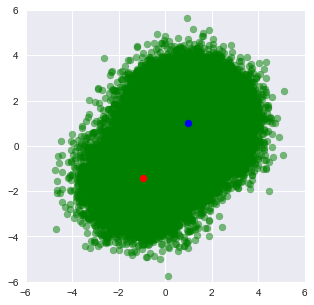

In [19]:
from copy import deepcopy

mu_0, sd_0 = means['mu_0'], sds['mu_0']
mu_1, sd_1 = means['mu_1'], sds['mu_1']

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')
plt.scatter(mu_0[0], mu_0[1], c="r", s=50)
plt.scatter(mu_1[0], mu_1[1], c="b", s=50)
plt.xlim(-6, 6)
plt.ylim(-6, 6)

The variance of the trace of ELBO is larger than without mini-batch because of the subsampling from the whole samples. 

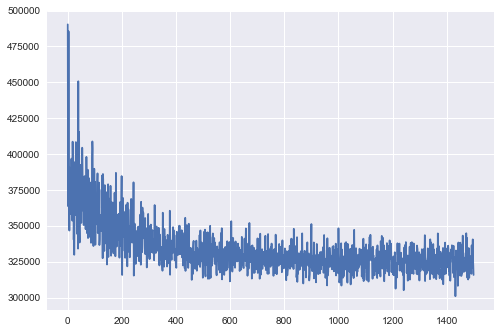

In [20]:
plt.plot(elbos);